## Importing Libraries

In [1]:
import glob
import shutil
import os
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.callbacks import *
%matplotlib inline

## Setting up DataBunch

In [2]:
train_df = pd.read_csv("train_v2.csv")
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
train_df.shape

(40479, 2)

In [4]:
data = ImageDataBunch.from_csv(path = ".",
                               folder = "train-jpg",
                               seed = 42,
                               csv_labels = "train_v2.csv",
                               size = 256,
                               suffix = ".jpg",
                               label_delim = " ",
                               ds_tfms = get_transforms(flip_vert = True, 
                                                        max_warp = 0.0, 
                                                        max_lighting = 0.1,
                                                        max_zoom = 1.05),
                               bs = 16,
                               num_workers = 4).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: .;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: .;

Test: None

In [5]:
print(data.classes)
print(data.c)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']
17


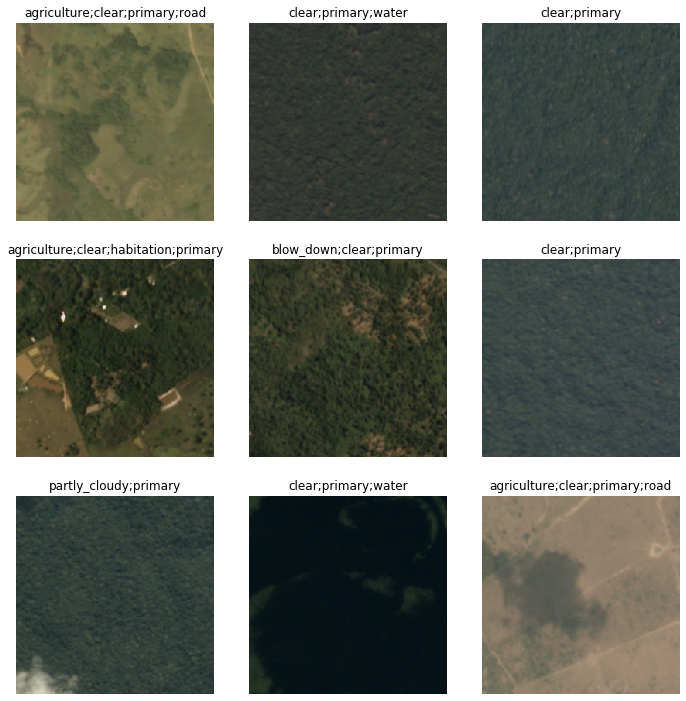

In [6]:
data.show_batch(3, figsize = (10,10))

## Creating and Fitting the Learner

In [7]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy_thresh, fbeta])

In [8]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.147793,0.126201,0.952796,0.884626,05:34
1,0.122731,0.109895,0.958762,0.903126,05:31
2,0.118657,0.102809,0.962540,0.908902,05:25
3,0.108868,0.098365,0.963477,0.915713,05:26
4,0.111413,0.094040,0.964364,0.916490,05:25
5,0.099832,0.092731,0.964742,0.918853,05:27
6,0.099543,0.089592,0.965709,0.923936,04:59
7,0.100755,0.088943,0.966167,0.924235,04:54
8,0.101593,0.090881,0.965418,0.920154,04:55
9,0.094701,0.088400,0.966232,0.924436,04:53


In [9]:
learn.save("model")

## Finetuning the Learner

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


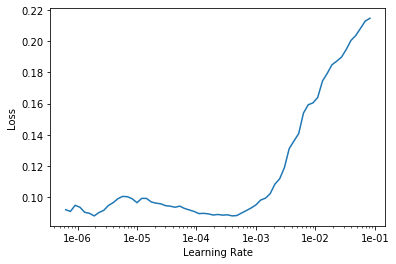

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(16, max_lr = slice((1e-5)/3,1e-4), callbacks = SaveModelCallback(learn))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.092383,0.089075,0.966014,0.923122,06:49
1,0.087649,0.089574,0.965825,0.922529,06:50
2,0.091222,0.089793,0.965542,0.922404,06:50
3,0.094883,0.089544,0.965599,0.923267,06:47
4,0.095849,0.087965,0.966704,0.925511,06:49
5,0.094770,0.088462,0.966232,0.925553,06:49
6,0.088594,0.088230,0.966559,0.923996,06:48
7,0.086193,0.087364,0.966726,0.924254,06:48
8,0.080108,0.087167,0.966770,0.925713,06:49
9,0.078820,0.086507,0.967053,0.926682,06:50


Better model found at epoch 0 with valid_loss value: 0.08907516300678253.
Better model found at epoch 4 with valid_loss value: 0.08796489238739014.
Better model found at epoch 7 with valid_loss value: 0.08736446499824524.
Better model found at epoch 8 with valid_loss value: 0.08716723322868347.
Better model found at epoch 9 with valid_loss value: 0.08650701493024826.
Better model found at epoch 10 with valid_loss value: 0.08605551719665527.
Better model found at epoch 13 with valid_loss value: 0.08571571856737137.
Better model found at epoch 14 with valid_loss value: 0.08541105687618256.


In [12]:
learn.export("trained_model.pkl")

# Inference on Test Images

In [13]:
test_data = ImageList.from_folder(path = "test-jpg").add(ImageList.from_folder(path = "test-jpg-additional"))
test_data

ImageList (61191 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: test-jpg

In [14]:
learn = load_learner(path = ".", file = "trained_model.pkl", test = test_data)

In [15]:
test_preds,_ = learn.get_preds(ds_type = DatasetType.Test)
print(test_preds.shape)

torch.Size([61191, 17])


In [16]:
thresh = 0.5
pred_labels = [" ".join([data.classes[i] for (i,p) in enumerate(pred) if p>0.2]) for pred in test_preds]

In [17]:
pred_labels[:5]

['clear primary',
 'clear primary',
 'partly_cloudy primary',
 'agriculture clear primary road water',
 'agriculture clear primary road water']

In [18]:
file_names = [file.name[:-4] for file in learn.data.test_ds.items]

In [19]:
df = pd.DataFrame({'image_name':file_names, 'tags':pred_labels})
df.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_10,partly_cloudy primary
3,test_100,agriculture clear primary road water
4,test_1000,agriculture clear primary road water


In [20]:
df.to_csv('output.csv', index=False)

The "output.csv" when submitted to Kaggle got a **Private Score** of **0.92474** and a **Public Score** of **0.92682**. 